<a href="https://colab.research.google.com/github/Niha0309/Assigments-Machine-Learning/blob/main/softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/assignment1/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/assignment1

Mounted at /content/drive
/content/drive/My Drive/assignment1/cs231n/datasets
/content/drive/My Drive/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [ ]:
# --- Standard imports ---
import random
import numpy as np
import matplotlib.pyplot as plt

# Plot settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# --- Autoreload workaround for Python 3.12+ ---
import importlib
import cs231n.classifiers.softmax
importlib.reload(cs231n.classifiers.softmax)

from cs231n.data_utils import load_CIFAR10
from cs231n.classifiers.softmax import softmax_loss_naive, softmax_loss_vectorized
from cs231n.classifiers import Softmax

# --- CIFAR-10 Data Loader ---
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    try:
        del X_train, y_train
        del X_test, y_test
    except:
        pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Reshape
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_val   = X_val.reshape(X_val.shape[0], -1)
    X_test  = X_test.reshape(X_test.shape[0], -1)
    X_dev   = X_dev.reshape(X_dev.shape[0], -1)

    # Standardize
    mean_image = np.mean(X_train, axis=0)
    std_image  = np.std(X_train, axis=0)
    X_train = (X_train - mean_image) / (std_image + 1e-7)
    X_val   = (X_val   - mean_image) / (std_image + 1e-7)
    X_test  = (X_test  - mean_image) / (std_image + 1e-7)
    X_dev   = (X_dev   - mean_image) / (std_image + 1e-7)

    # Bias trick
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val   = np.hstack([X_val,   np.ones((X_val.shape[0],   1))])
    X_test  = np.hstack([X_test,  np.ones((X_test.shape[0],  1))])
    X_dev   = np.hstack([X_dev,   np.ones((X_dev.shape[0],   1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev

# --- Load data ---
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()

# --- Sanity check loss ---
W = np.random.randn(X_train.shape[1], 10) * 0.0001
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.0)
loss_vec, grad_vec = softmax_loss_vectorized(W, X_dev, y_dev, 0.0)
print('Naive loss:', loss_naive, 'Vectorized loss:', loss_vec)

# --- Hyperparameter search ---
results = {}
best_val = -1
best_softmax = None

learning_rates = np.logspace(-8, -5, num=4)
regularization_strengths = np.logspace(2, 4, num=4)

for lr in learning_rates:
    for reg in regularization_strengths:
        sm = Softmax()
        sm.train(X_train, y_train,
                 learning_rate=lr,
                 reg=reg,
                 num_iters=2000,
                 batch_size=200,
                 verbose=False)

        y_train_pred = sm.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = sm.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)

        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = sm

# --- Print all results ---
for (lr, reg), (train_acc, val_acc) in sorted(results.items()):
    print('lr %e reg %e train accuracy: %f val accuracy: %f' %
          (lr, reg, train_acc, val_acc))
print('Best validation accuracy: %f' % best_val)

# --- Evaluate on test set ---
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Test set accuracy: %f' % test_accuracy)


Naive loss: 2.302802350917042 Vectorized loss: 2.302802350917042
lr 1.000000e-08 reg 1.000000e+02 train accuracy: 0.091898 val accuracy: 0.104000
lr 1.000000e-08 reg 4.641589e+02 train accuracy: 0.113102 val accuracy: 0.097000
lr 1.000000e-08 reg 2.154435e+03 train accuracy: 0.111184 val accuracy: 0.102000
lr 1.000000e-08 reg 1.000000e+04 train accuracy: 0.098122 val accuracy: 0.106000
lr 1.000000e-07 reg 1.000000e+02 train accuracy: 0.103837 val accuracy: 0.108000
lr 1.000000e-07 reg 4.641589e+02 train accuracy: 0.102204 val accuracy: 0.090000
lr 1.000000e-07 reg 2.154435e+03 train accuracy: 0.104286 val accuracy: 0.116000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.216224 val accuracy: 0.219000
lr 1.000000e-06 reg 1.000000e+02 train accuracy: 0.212755 val accuracy: 0.229000
lr 1.000000e-06 reg 4.641589e+02 train accuracy: 0.246224 val accuracy: 0.245000
lr 1.000000e-06 reg 2.154435e+03 train accuracy: 0.251735 val accuracy: 0.260000
lr 1.000000e-06 reg 1.000000e+04 train accur

Inline Question 1

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

There are 10 classes which means that, on average, there is 0.1 probability to correctly classify the true label by guessing randomly. Since our weights are intialized randomly and since the pure softmax squashes a vector of raw scores into probabilities, the probability of getting a correct guess is also 0.1. We expect -log(0.1) because the actuall loss function calculates cross-entropy.

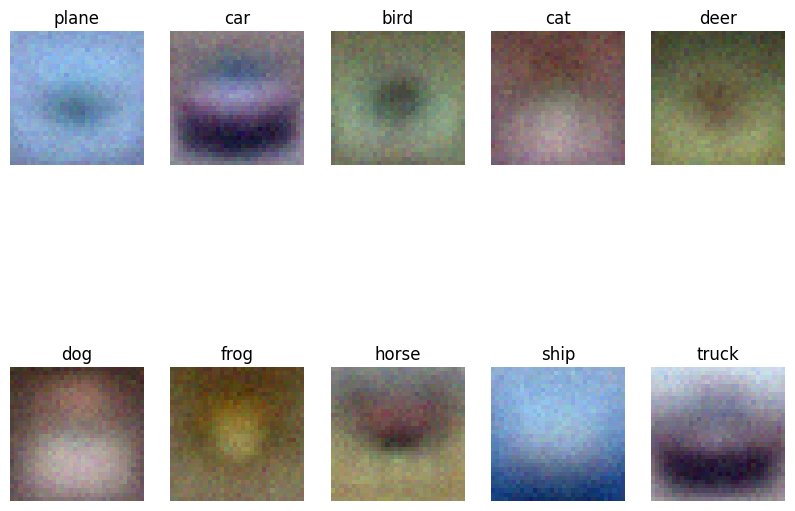

In [ ]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])